# Modules

In [1]:
import pandas as pd # routine analysis with dataframes
import numpy as np # routine array analysis
import pickle # reading in pickle files (PCA morphospace file)
from scipy.spatial import ConvexHull # for calculating convex hull of morphospace
from scipy.spatial import Delaunay # for delauney triangulation functions
from scipy.stats import dirichlet # for sampling simplices in the morphospace
from numpy.linalg import det # for sampling simplices in the morphospace
import math # for math functions
import os # for directory functions
import matplotlib.pyplot as plt # for plotting
from shapely.geometry import Polygon, Point # for point and polygon operations
from shapely.ops import nearest_points # for calculating leaf curvature
import trimesh # for working with triangular meshes and ray casting
import seaborn as sns # for plotting results
import matplotlib.lines as mlines # for data visualization dividers in plt.subplot

# Functions

In [2]:
def save_params(keys, values, path):

    """
    Given lists of parameter variable names and values, saves as csv file to desired path
    
    Inputs 
    keys: a list of keys, parameter names
    values: a list of values, parameter values
    path: a filename path to save the param values as .csv file

    Outputs:
    No return, saves the csv to the desired path
    """
    
    # convert values into lists
    list_vals = [[x] for x in values]
    
    # convert parameter names and values into dictionary
    data = dict(zip(keys, list_vals))
    
    # convert dict into df
    df = pd.DataFrame.from_dict(data)
    
    # save param values
    df.to_csv(path, index=False)

def set_params(path):

    """
    Given a path, read in a csv file with parameter variable names and values
    
    Inputs 
    path: a filename path to read in a csv 

    Outputs:
    Sets global variables and values from the csv file
    Returns a dictionary of parameter names and values
    """
    
    # read in param values from csv
    df = pd.read_csv(path)
    
    # create variables for parameters
    for column in df.columns:
        globals()[column] = df[column].item()

    # create a dictionary of parameter variables to return
    param_var_list = [
        "parameter_name", 
        "morphospace_file", 
        "PC_val_file",
        "PCa", 
        "PCb",
        "grid_density",
        "low_lf_num",
        "high_lf_num",
        "low_juv_len",
        "high_juv_len",
        "low_adult_len",
        "high_adult_len",
        "lf_curve",
        "lf_curl",
        "max_down_curl",
        "max_up_curl",
        "ang_min_limit",
        "ang_max_limit",
        "phyllo_option"]

    param_val_list = [
        parameter_name, 
        morphospace_file, 
        PC_val_file,
        PCa, 
        PCb,
        grid_density,
        low_lf_num,
        high_lf_num,
        low_juv_len,
        high_juv_len,
        low_adult_len,
        high_adult_len,
        lf_curve,
        lf_curl,
        max_down_curl,
        max_up_curl,
        ang_min_limit,
        ang_max_limit,
        phyllo_option]
    
    # convert parameter names and values into dictionary
    param_var_dict = dict(zip(param_var_list, param_val_list))

    return param_var_dict

def dist_in_hull(points, n):

    """
    From: https://stackoverflow.com/questions/59073952/how-to-get-uniformly-distributed-points-in-convex-hull
    Accessed 11 February 2024
    
    Given a set of points, find delauney simplices of hull and randomly sample n points within

    Inputs:
    points: an array of point values, any dimensions
    n: the number of points to sample within the convex hull

    Outputs
    coordinates of randomly sampled points (array)
    """
    
    dims = points.shape[-1]
    hull = points[ConvexHull(points).vertices]
    deln = hull[Delaunay(hull).simplices]

    vols = np.abs(det(deln[:, :dims, :] - deln[:, dims:, :])) / math.factorial(dims)    
    sample = np.random.choice(len(vols), size = n, p = vols / vols.sum())

    return np.einsum('ijk, ij -> ik', deln[sample], dirichlet.rvs([1]*(dims + 1), size = n))

def select_leaf_number(low_lf_num, high_lf_num):
    """
    Given low and high leaf number values, uniformly sample a leaf number for the plant
    
    Inputs
    low_lf_num: integer value of lowest possible leaf number (inclusive)
    high_lf_num: integer value of highest possible leaf number (not included)

    Ouputs
    n: the selected leaf number uniformly sampled from provided range
    """

    return np.random.randint(low_lf_num, high_lf_num) 

def select_phyllotaxy_angle(phyllo_option):
    """
    Given a phyllotaxy angle option value (see below) set phyllotaxy angle

    Inputs
    phyllo_option: integer value selecting phyllotaxy option

    Outputs
    phyllo_ang: float value of calculated phyllotaxy angle
    """

    # 0 = [-137.5077640500378546463487,137.5077640500378546463487]
    # 1 = [-137.5077640500378546463487,137.5077640500378546463487,90,180]
    # 2 = [-137.5077640500378546463487,137.5077640500378546463487,90,180,<random -360 to +360>]
    # 3 = [<random -360 to +360>]

    if phyllo_option==0:
        phyllo_ang=np.random.choice(np.array([-137.5077640500378546463487,137.5077640500378546463487]))
    elif phyllo_option==1:
        phyllo_ang=np.random.choice(np.array([-137.5077640500378546463487,137.5077640500378546463487,90,180]))
    elif phyllo_option==2:
        phyllo_ang=np.random.choice(np.array([-137.5077640500378546463487,137.5077640500378546463487,90,180,np.random.uniform(-360,360)]))
    else:
        phyllo_ang=np.random.uniform(-360,360)

    return phyllo_ang

def select_leaf_lengths(low_juv_len, high_juv_len, low_adult_len, high_adult_len):
    """
    Given relative leaf lengths of start (juvenile) and end (adult) of leaf series, set relative leaf lengths

    Inputs
    low_juv_len: low limit juvenile leaf length (relative to 1)
    high_juv_len: high limit juvenile leaf length (relative to 1)
    low_adult_len: low limit adult leaf length (relative to 1)
    high_adult_len: high limit adult leaf length (relative to 1)

    Outputs
    juv_len: the relative length to 1 of juvenile leaf
    adult_len: the relative length to 1 of the adult leaf
    node_max: the node in the leaf series of the max leaf height (from 0 to 1)
    """
    # select relative height of first leaf in series
    juv_len = np.random.uniform(low_juv_len, high_juv_len) 
    
    # set node position of max leaf height of 1 (0 to 1)
    node_max = np.random.uniform(0.1, 0.9) # a little bit in from 0 and 1 at 0.1 to 0.9
    
    # set the relative height of last leaf in series
    adult_len = np.random.uniform(low_adult_len, high_adult_len) 

    return juv_len, adult_len, node_max

def select_leaf_surface_variables(lf_curve, lf_curl, max_down_curl, max_up_curl):
    """
    Given curvature and curling scaling values and positioning of curling, return leaf surface (z axis) values

    Inputs:
    lf_curve: scaling factor for the amount of leaf curvature (relative to leaf margins)
    lf_curl: scaling factor for the amount of leaf curling (from base to tip)
    max_down_curl: a 0 to 1 value of maximum downward curl
    max_up_curl: a 0 to 1 value of maximum upward curl

    Outputs:
    leaf_curve: the leaf curvature scaling amount
    leaf_curl: the leaf curling scaling amount
    leaf_tip: the leaf curling value at the tip of the leaf
    leaf_mid: the leaf curling value at the mid point of the leaf length
    """
    # calculate the scaling factor for leaf curvature and leaf curl
    leaf_curve = np.random.uniform(0,lf_curve) 
    leaf_curl = np.random.uniform(0,lf_curl) 
    
    # calculate leaf curl amount (z value)
    leaf_tip = np.random.uniform(max_down_curl,max_up_curl) 
    
    # set middle of leaf curl (also z value, but curl at mid point of length)
    leaf_mid = np.random.uniform(0,leaf_tip) 

    return leaf_curve, leaf_curl, leaf_tip, leaf_mid

def select_leaf_elevation_angles(ang_min_limit, ang_max_limit):
    """
    Given the minimum and maximum leaf angle limits, calculate the leaf elevation limits

    Inputs
    ang_min_limit: the minimum angle limit (in the context of 0 to the limit)
    ang_max_limit: the maximum angle limit (in the context of the selected min angle to the max limit)

    Outputs
    angle_min: the selected minimum angle value
    angle_max: the selected maximum angle value
    """
    # calculate elevation angles
    angle_min = np.random.uniform(0,ang_min_limit) # get the minimum angle
    angle_max = np.random.uniform(angle_min,ang_max_limit) # get the maximum angle\

    return angle_min, angle_max

def select_morphospace_points(morphospace_file, PC_val_file, PCa, PCb):
    """
    Given a morphospace and PC values select morphospace points to generate a leaf shape series

    Inputs
    morphospace_file: path to a morphospace file (.pkl)
    PC_val_file: path to PC value file (.npy)
    PCa: the first PC axis to consider (index starts at 0)
    PCb: the second PC axis to consider (index starts at 0)

    Outputs:
    start_x: the x value (PCa) of the leaf series start
    start_y: the y value (PCb) of the leaf series start
    end_x: the x value (PCa) of the leaf series end
    end_y: the y value (PCb) of the leaf series end
    """
    # find the two points in PCA space to make the leaf series
    # Load PCA model
    with open(morphospace_file, 'rb') as file:
        pca = pickle.load(file)
    # Load in PC values
    PCs = np.load(PC_val_file)
    
    # retrieve just the desired two PCs
    just_PCs = PCs[:,[PCa,PCb]]
    # create the convex hull
    hull = ConvexHull(just_PCs)
    # retreieve hull points
    hull_points = just_PCs[hull.vertices]
    # find two random points in 2D convex hull
    # these are the terminal points of the line
    term_pts = dist_in_hull(hull_points,2)
    # these are the values of the coordinate points
    start_x = term_pts[0][0]
    start_y = term_pts[0][1]
    end_x = term_pts[1][0]
    end_y = term_pts[1][0]

    return start_x, start_y, end_x, end_y

def save_model_values(param_var_dict, model_results_path, n_models):
    """
    Given parameter values, generate and save values to create models

    Inputs
    param_var_dict: a dictionary of parameter variables and values
    model_results_path: path to create a folder to save model values
    n_models: the desired number of model values to save

    Outputs
    No return, but save desirved number of model values in specified folder as csv files
    """

    if not os.path.exists(model_results_path): # check if the folder exists
        # create the folder if it doesn't exist
        os.makedirs(model_results_path)

    # unpack parameter variable list
    parameter_name=param_var_dict["parameter_name"]
    morphospace_file=param_var_dict["morphospace_file"]
    PC_val_file=param_var_dict["PC_val_file"]
    PCa=param_var_dict["PCa"]
    PCb=param_var_dict["PCb"]
    grid_density=param_var_dict["grid_density"]
    low_lf_num=param_var_dict["low_lf_num"]
    high_lf_num=param_var_dict["high_lf_num"]
    low_juv_len=param_var_dict["low_juv_len"]
    high_juv_len=param_var_dict["high_juv_len"]
    low_adult_len=param_var_dict["low_adult_len"]
    high_adult_len=param_var_dict["high_adult_len"]
    lf_curve=param_var_dict["lf_curve"]
    lf_curl=param_var_dict["lf_curl"]
    max_down_curl=param_var_dict["max_down_curl"]
    max_up_curl=param_var_dict["max_up_curl"]
    ang_min_limit=param_var_dict["ang_min_limit"]
    ang_max_limit=param_var_dict["ang_max_limit"]
    phyllo_option=param_var_dict["phyllo_option"]

    for m in range(n_models):
    
        # select number of leaves
        n = select_leaf_number(low_lf_num, high_lf_num)
    
        # select phyllotactic angle
        phyllo_ang = select_phyllotaxy_angle(phyllo_option)
    
        # select leaf lengths
        juv_len, adult_len, node_max = select_leaf_lengths(low_juv_len, high_juv_len, low_adult_len, high_adult_len)
    
        # select leaf surface variables
        leaf_curve, leaf_curl, leaf_tip, leaf_mid = select_leaf_surface_variables(lf_curve, lf_curl, max_down_curl, max_up_curl)
    
        # select leaf elevation angles
        angle_min, angle_max = select_leaf_elevation_angles(ang_min_limit, ang_max_limit)
    
        # select morphospace points
        start_x, start_y, end_x, end_y = select_morphospace_points(morphospace_file, PC_val_file, PCa, PCb)
    
        model_var_list = [
            "n",
            "phyllo_ang",
            "juv_len",
            "adult_len",
            "node_max",
            "leaf_curve",
            "leaf_curl",
            "leaf_tip",
            "leaf_mid",
            "angle_min",
            "angle_max",
            "start_x",
            "start_y",
            "end_x",
            "end_y"
           ]
    
        model_val_list = [
            n,
            phyllo_ang,
            juv_len,
            adult_len,
            node_max,
            leaf_curve,
            leaf_curl,
            leaf_tip,
            leaf_mid,
            angle_min,
            angle_max,
            start_x,
            start_y,
            end_x,
            end_y
            ]

        # convert values into lists
        model_val_list = [[x] for x in model_val_list]
    
        # convert parameter names and values into dictionary
        model_var_dict = dict(zip(model_var_list, model_val_list))

        # convert dict into df
        df = pd.DataFrame.from_dict(model_var_dict)
        
        # save param values
        df.to_csv("./" + model_results_path + "/m" + str(m) + "_" + parameter_name + ".csv", index=False)

def set_model_values(path):
    """
    Given a model values file, read in and set model values

    Inputs
    path: a path to a model value .csv file

    Outputs
    model_var_dict: a dictionary of model values
    The function sets global values for model variables
    """

    # read in model values from csv
    df = pd.read_csv(path)
    
    # create variables for parameters
    for column in df.columns:
        globals()[column] = df[column].item()
    
    # create a dictionary of model values to return
    model_var_list = [
        "n",
        "phyllo_ang",
        "juv_len",
        "adult_len",
        "node_max",
        "leaf_curve",
        "leaf_curl",
        "leaf_tip",
        "leaf_mid",
        "angle_min",
        "angle_max",
        "start_x",
        "start_y",
        "end_x",
        "end_y"
       ]
    
    model_val_list = [
        n,
        phyllo_ang,
        juv_len,
        adult_len,
        node_max,
        leaf_curve,
        leaf_curl,
        leaf_tip,
        leaf_mid,
        angle_min,
        angle_max,
        start_x,
        start_y,
        end_x,
        end_y
        ]
    
    # convert model names and values into dictionary
    model_var_dict = dict(zip(model_var_list, model_val_list))

    return model_var_dict

def read_in_morphospace(morphospace_file, PC_val_file):
    """
    Given paths to morphospace and PC value files, read in the data

    Inputs
    morphospace_file: path to a pickle file (.pkl) of the PCA model (the morphospace)
    PC_val_file: path to a numpy file (.npy) of an array of the PC values

    Outputs
    pca: the PCA model of the morphospace
    PCs: an array of PC values
    """
    pca = pickle.load(open(morphospace_file,'rb')) 
    PCs = np.load(PC_val_file)

    return pca, PCs

def generate_leaf_series(n,start_x,start_y,end_x,end_y,PCs,PCa,PCb,pca):
    """
    Given a morphospace and start and end point, generate a leaf series for n leaves between the points

    Inputs
    n: the number of leaves in the series to generate
    start_x, start_y: x,y coords of the start point in PCA space
    end_x, end_y: x,y coords of the end point in PCA space
    PCs: an array of PC values
    PCa: index position of the "x axis" PC to use (index starts at 0)
    PCb: index position of the "y axis" PC to use (index starts at 0)
    pca: a predefined morphospace PCA model

    Ouputs
    leaf_series: a 3D array of the eigenleaves in the series
    """

    # Create an array of evenly spaced values from 0 to 1
    t_values = np.linspace(0, 1, n)

    # define start and end points of leaf series
    start_point = np.array([start_x, start_y])
    end_point = np.array([end_x, end_y])
    
    # Calculate the points using linear interpolation
    points = np.array([start_point + t * (end_point - start_point) for t in t_values])
    
    # calculate eigen leaves
    eigen_arr = np.zeros((len(points),np.shape(PCs)[1])) # create an array for eigenleaf, length of number of PCs
    eigen_arr[:,PCa] = points[:,0] # set the PCa values
    eigen_arr[:,PCb] = points[:,1] # set the PCb values
    
    # calculate the inverse eigenleaf
    inv_leaf = pca.inverse_transform(eigen_arr)
    inv_x = inv_leaf[:,0::2] # select just inverse x vals
    inv_y = inv_leaf[:,1::2] # select just inverse y vals
    
    # create an array of the leaf series
    leaf_series = np.stack((inv_x, inv_y), axis=1)
    leaf_series = np.swapaxes(leaf_series, 1,2)

    return leaf_series

def is_self_intersecting(polygon_coordinates):
    """
    Checks if a polygon is self-intersecting.

    Args:
        polygon_coordinates: A list of (x, y) tuples representing the polygon's vertices.

    Returns:
        True if the polygon is self-intersecting, False otherwise.
    """
    polygon = Polygon(polygon_coordinates)
    return not polygon.is_simple

def any_leaf_self_intersecting(leaf_series):
    """
    Given an array representing leaves in the leaf series, determine if any are self-intersecting polygons

    Inputs
    leaf_series: a 3D array of 2D leaf shapes in the leaf series

    Outputs
    True/False: is any leaf shape in the series self-intersecting?
    """

    for i in range(len(leaf_series)):
        if is_self_intersecting(leaf_series[i]):
            return True
        else:
            continue

    return False

def translate_base_to_origin(leaf_series):
    """
    Given a leaf series, return each leaf in the series translated with its base to the origin

    Inputs
    leaf_series: a 3D array of a leaf series

    Outputs
    trans_lfs: 1 3D array of the leaf series with bases translated to the origin
    """

    trans_lfs = np.zeros(np.shape(leaf_series))
    
    for i in range(len(leaf_series)):
        start_pt = leaf_series[i,0,:] # leaf start
        end_pt = leaf_series[i,-1,:] # leaf end
        base_pt = np.mean((start_pt, end_pt), axis=0) # base point of leaf
        trans_lf = leaf_series[i,:,:] - base_pt # translated lf
        trans_lfs[i,:,:] = trans_lf # save translated lf

    return trans_lfs

def scale_leaf_series(node_max, juv_len, adult_len, trans_lfs, n):
    """
    Given 1) a leaf series 2) with each leaf base translated to the origin, use a funciton to calculate leaf lengths across the series

    Inputs
    node_max: for nodes across the leaf series 0 to 1, the value where the leaf length is the maximum value
    juv_len, adult_len: the relative lengths of the leaves (0 to 1) for the first (juvenile) and last (adult) node respectively
    trans_lfs: a 3D array of leaf shapes for a leaf series to calculate lengths for each leaf for

    Outputs
    scaled_lfs: a 3D array for a leaf series where the length of each leaf has been scaled appropriately
    """
    
    # find relative lengths for each leaf (to 1)
    coeffs = np.polyfit(x=[0,node_max,1], y=[juv_len,1,adult_len], deg=2) # calculate coefficients
    func = np.poly1d(coeffs) # calculate 2D polynomial function
    lf_lens = func(np.linspace(0,1,n)) # calculate leaf lengths relative to 1
    
    scaled_lfs = np.zeros(np.shape(trans_lfs))
    for i in range(len(scaled_lfs)): # for each leaf in the series
        scale_len_lf = trans_lfs[i,:,:]/np.max(trans_lfs[i,:,1]) # scale leaf len to 1
        scale_len_lf = scale_len_lf*lf_lens[i] # scale leaf to desired length
        scaled_lfs[i,:,:] = scale_len_lf # save scaled length leaf

    return scaled_lfs

def save_leaf_series(file,leaf_series_path,n_save,start_x,start_y,end_x,end_y,PCs,PCa,PCb,pca,node_max,juv_len,adult_len):
    """
    Save an array of leaf shapes across the series with the same number of leaves for comparison

    Inputs
    In addition to parameters needed for the previous functions:
    file: the current model_values file name, to retrieve the number ID of the current model to save the leaf series
    leaf_series_path: a folder name to save the leaf series files as arrays
    n_save: this is different from n, the number of leaves in the series. n_save is the standard number of leaves to save for the leaf series

    Outputs
    No return, saves the leaf series array as a .npy file to the specified folder path
    """

    # generate a leaf series to save for the desired number of leaves
    nsave_lf_series = generate_leaf_series(n_save,start_x,start_y,end_x,end_y,PCs,PCa,PCb,pca)
    # translate each leaf base to the origin
    trans_nsave_lf_series = translate_base_to_origin(nsave_lf_series)
    # scale leaves across the series to the appropriate length
    scale_nsave_lf_series = scale_leaf_series(node_max, juv_len, adult_len, trans_nsave_lf_series, n=n_save)

    if not os.path.exists(leaf_series_path): # check if the folder exists
        # create the folder if it doesn't exist
        os.makedirs(leaf_series_path)

    # save the leaf series 
    np.save(leaf_series_path + "/" + "l" + file[1:-4], scale_nsave_lf_series)

def hexagonal_points_for_n(vertices_2d: np.ndarray, target_n: int) -> np.ndarray:
    """
    Given a 2D polygon, provide hexagonally spaced points of the approximate target number

    Inputs
    vertices: a 2D array of the polygon boundaries
    grid_density: the approximate number of points within the polygon

    Outputs
    hex_pts: a 2D array of hexagonal grid points
    """

    poly = Polygon(vertices_2d)
    area = poly.area

    # Estimate point density of hex grid: ~1 point per (sqrt(3)/2)*spacing^2 area
    hex_cell_area = area / target_n
    spacing = np.sqrt((2 * hex_cell_area) / np.sqrt(3))

    minx, miny, maxx, maxy = poly.bounds
    dx = spacing
    dy = spacing * np.sqrt(3) / 2

    points = []
    j = 0
    y = miny
    while y <= maxy:
        x_offset = (dx / 2) if (j % 2 == 1) else 0
        x = minx + x_offset
        while x <= maxx:
            p = Point(x, y)
            if poly.contains(p):
                points.append([x, y])
            x += dx
        y += dy
        j += 1

    return np.array(points)

def delaunay_triangulation_within_polygon(points, polygon):
    """
    Generates a Delaunay triangulation of a set of points that lie within a given polygon.

    Args:
        points: A list of (x, y) coordinate tuples or a NumPy array of shape (n, 2) representing the points.
        polygon: A {Link: Shapely Polygon https://shapely.readthedocs.io/en/stable/manual.html#polygon} object representing the polygon.

    Returns:
        A tuple containing:
        - A NumPy array of shape (n, 2) representing the coordinates of the vertices of the triangulation.
        - A NumPy array of shape (m, 3) representing the indices of the vertices that form each triangle.
    """

    # Create Delaunay triangulation
    delaunay = Delaunay(points)

    # Filter triangles that fall outside the polygon
    triangles_within_polygon = []
    for triangle_indices in delaunay.simplices:
        triangle_points = points[triangle_indices]
        triangle_polygon = Polygon(triangle_points)

        if triangle_polygon.within(polygon):
            triangles_within_polygon.append(triangle_indices)

    # Return the filtered triangles
    return points, np.array(triangles_within_polygon)

def shortest_distance_to_polygon(point_coords, polygon_coords):
    """
    Calculates the shortest distance from a point to a polygon outline.

    Args:
        point_coords (tuple): Coordinates of the point (x, y).
        polygon_coords (list): List of coordinate tuples defining the polygon's vertices.

    Returns:
        float: The shortest distance from the point to the polygon outline.
    """
    point = Point(point_coords)
    polygon = Polygon(polygon_coords)

    # Get the boundary (outline) of the polygon as a LinearRing
    polygon_boundary = polygon.boundary

    # Find the nearest point on the polygon boundary to the given point
    nearest_point = nearest_points(point, polygon_boundary)[1]

    # Calculate the distance between the point and the nearest point on the boundary
    distance = point.distance(nearest_point)

    return distance

def rotate_points(xvals, yvals, degrees):
    """"
    define a function to rotate 2D x and y coordinate points around the origin
    inputs: x and y vals (can take pandas dataframe columns) and the degrees (positive, anticlockwise) to rotate
    outputs: rotated and y vals
    """
    angle_to_move = 90-degrees
    rads = np.deg2rad(angle_to_move)
    
    new_xvals = xvals*np.cos(rads)-yvals*np.sin(rads)
    new_yvals = xvals*np.sin(rads)+yvals*np.cos(rads)
    
    return new_xvals, new_yvals

def preserve_area(vertices_2d, faces, z_raw):
    """
    Given an array of 2D vertices, indices of triangular faces, and z values, warp triangles into z axis while preserving area

    Inputs
    vertices_2d: array of 2D points
    faces: indices of triangle faces
    z_raw: z axis values into 3D plane

    Outputs
    z_adjusted: adjusted z values
    """
    
    vertices_3d = np.hstack([vertices_2d, z_raw[:, np.newaxis]])
    z_adjusted = z_raw.copy()

    for tri in faces:
        i0, i1, i2 = tri
        p0, p1, p2 = vertices_2d[[i0, i1, i2]]
        a_2d = triangle_area_2d(p0, p1, p2)

        p0_3d = np.array([*p0, z_adjusted[i0]])
        p1_3d = np.array([*p1, z_adjusted[i1]])
        p2_3d = np.array([*p2, z_adjusted[i2]])
        a_3d = triangle_area_3d(p0_3d, p1_3d, p2_3d)

        if a_3d == 0 or a_2d == 0:
            continue  # skip degenerate triangles

        scale = np.sqrt(a_2d / a_3d)

        # Scale the Z-values locally to match the area
        centroid_z = (z_adjusted[i0] + z_adjusted[i1] + z_adjusted[i2]) / 3.0
        for i in [i0, i1, i2]:
            deviation = z_adjusted[i] - centroid_z
            z_adjusted[i] = centroid_z + deviation * scale

    return z_adjusted

def triangle_area_2d(p0, p1, p2):
    return 0.5 * np.abs((p1[0] - p0[0]) * (p2[1] - p0[1]) -
                        (p2[0] - p0[0]) * (p1[1] - p0[1]))

def triangle_area_3d(p0, p1, p2):
    v1 = p1 - p0
    v2 = p2 - p0
    return 0.5 * np.linalg.norm(np.cross(v1, v2))

def sample_hex_grid(scaled_lfs,grid_density):
    """
    For a 2D outline, sample approximately n points in a regular hexagon pattern within

    Inputs
    scaled_lfs: a 3D array of 2D leaf outlines across the leaf series
    grid_density: the number of points to sample in a hexagonal grid within the leaf

    Outputs
    pts: a list of arrays for each leaf of the sampled hexagonal grid
    tris: a list of arrays for each leaf of the pts indices that form triangular faces
    """

    pts = [] # store each array of hex points for the leaves
    tris = [] # store each array of face triangles for the leave
    for i in range(len(scaled_lfs)):
        hex_pts = hexagonal_points_for_n(scaled_lfs[i], grid_density) # calculate grid of hex points
        verts, faces = delaunay_triangulation_within_polygon(hex_pts, Polygon(scaled_lfs[i])) # calculate Delauney triangulation
        pts.append(verts) # save triangle points
        tris.append(faces) # save triangle faces

    return pts, tris

def lift_points_radially(points_3d, angle_degrees):
    """
    Rotates each point around the axis perpendicular to its (x, y) vector,
    lifting it into the Z direction by the given angle.
    Points at the origin remain unchanged.

    Parameters:
        points_3d (np.ndarray): Nx3 array of points (x, y, z)
        angle_degrees (float): Angle in degrees to lift into Z

    Returns:
        np.ndarray: Nx3 array of rotated 3D points
    """
    angle_radians = np.deg2rad(angle_degrees)
    lifted_points = []

    for x, y, z in points_3d:
        if np.isclose(x, 0) and np.isclose(y, 0):
            # Leave origin fixed
            lifted_points.append([0, 0, z])
            continue

        # Get direction vector in XY plane from origin to point
        v_xy = np.array([x, y, 0])
        norm_xy = np.linalg.norm(v_xy)
        v_xy_unit = v_xy / norm_xy

        # Axis of rotation is perpendicular to (x, y, 0) in the XY plane
        # Cross with Z to get rotation axis
        axis = np.cross(v_xy_unit, [0, 0, 1])  # This is the rotation axis
        axis = axis / np.linalg.norm(axis)

        # Rodrigues' rotation formula
        v = np.array([x, y, z])
        k = axis
        cos_theta = np.cos(angle_radians)
        sin_theta = np.sin(angle_radians)

        v_rot = (v * cos_theta +
                 np.cross(k, v) * sin_theta +
                 k * np.dot(k, v) * (1 - cos_theta))

        lifted_points.append(v_rot)

    return np.array(lifted_points)

def generate_3D_points(pts,scaled_lfs,leaf_curve,leaf_mid,leaf_tip,leaf_curl,phyllo_ang,warp,angle_min,angle_max, n):
    """
    Given 2D grid points, use functions to calculate leaf curvature and curl, rotation, and elevation

    Inputs
    pts: a list of arrays of 2D hexagonal grid points
    scaled_lfs: an array of leaf shapes scaled by length with base at origin
    leaf_curve, leaf_mid, leaf_tip, leaf_curl: parameters for specifying 3D leaf surface
    phyllo_ang: angle to rotate leaf for each successive node
    warp: True/False, whether to preserve triangle surface area when moving into z axis
    angle_min, angle_max: parameters to calculate leaf elevation angles
    n: the number of leaves in the leaf series

    Outputs
    pts_3D: a list of x, y, z vertices for leaf shape
    """

    pts_3D = [] # list of x,y,z vertices
    
    for i in range(len(pts)): # for each leaf in the list of arrays of points and triangle faces
    
        # LEAF CURVATURE
        # get distances of each grid point to polygon boundary
        dists=[]
        for j in range(len(pts[i])):
            dists.append(shortest_distance_to_polygon((pts[i][j,0],pts[i][j,1]),scaled_lfs[i]))
        scaled_lf_curve = np.array(dists)*leaf_curve # get scaled leaf curvature
        
        # LEAF CURL
        # calculate leaf curl from distance to base
        coeffs = np.polyfit(x=[0,0.5,1], y=[0,leaf_mid,leaf_tip], deg=2) # calculate coefficients
        func = np.poly1d(coeffs) # calculate 2D polynomial function
        
        lf_curl_vals = func(pts[i][:,1])*leaf_curl*np.max(pts[i][:,1]) # calculate leaf lengths relative to 1
        
        # OVERALL Z SURFACE CALCULATION
        lf_surf_vals = scaled_lf_curve+lf_curl_vals # calculate overall curvature
        lf_surf_lf = np.column_stack((pts[i], lf_surf_vals)) # combine x, y, and z vals
        
        # translate the z axis to the origin
        lf_surf_lf[:,2] = lf_surf_lf[:,2] - np.mean(lf_surf_lf[:,2][lf_surf_lf[:,1]==np.min(lf_surf_lf[:,1])] )
        
        # ROTATE LEAF
        rot_x, rot_y = rotate_points(lf_surf_lf[:,0],lf_surf_lf[:,1], phyllo_ang*i)
        lf_surf_lf[:,0:2] = np.column_stack((rot_x, rot_y))
        
        if warp==True:
        
            # Warp Dlauney triangulation into 3D
            # get surface values of leaf
            z_raw = lf_surf_lf[:,2]
            
            # get the x and y coordinate values
            vertices_2d = lf_surf_lf[:,0:2]
            
            # Area-preserving adjustment
            z_warped = preserve_area(vertices_2d, tris[i], z_raw)
            
            # Now vertices_3d = [x, y, z_warped]
            vertices_3d = np.hstack([vertices_2d, z_warped[:, np.newaxis]])
        
        else:
            vertices_3d = lf_surf_lf
        
        # Elevate the leaves
        # elevate the points
        angs = np.linspace(angle_min, angle_max, n)
        elv_pts = lift_points_radially(vertices_3d, angs[i])
        
        pts_3D.append(elv_pts) # append points to list

    return pts_3D

def fibonacci_sphere(samples=1000):
    """
    For the number of samples, calculate a hemisphere of points arranged in an equally spaced Fibonacci pattern

    Inputs:
    samples: the number of points to calculate for a sphere (will return half as much as a hemisphere

    Outputs:
    points: a list of points sampled from the hemisphere
    """
    points = []
    phi = math.pi * (math.sqrt(5.) - 1.)  # golden angle in radians
    for i in range(samples):
        y = 1 - (i / float(samples - 1)) * 2  # y goes from 1 to -1
        radius = math.sqrt(1 - y * y)  # radius at y
        theta = phi * i  # golden angle increment
        x = math.cos(theta) * radius
        z = math.sin(theta) * radius
        points.append((x, y, z))
    return points

def ray_casting(pts_3D, tris, n_origins, radius, n_sample):
    """
    For a 3D model of points and triangular faces, perform a ray casting experiment to test for proportion of intercepted rays

    Inputs
    pts_3D: a list of 3D arrays of leaf surfaces in the series
    tris: a list of arrays of vertices of triangular faces for each leaf
    n_origins: the number of Fibonacci sphere points to sample for ray origins
    radius: the radius of the sphere
    n_sample: the number of rays to subsample

    Outputs
    proportion_correct: the proportion of rays that intercepted their intended leaf surface face
    total_area: the total surface area of the mesh
    """

    #####
    # NORMALIZE RADIUS TO FARTHEST POINT FROM ORIGIN
    #####
    
    dists = []
    for i in range(len(pts_3D)):
        for j in range(len(pts_3D[i])):
            dists.append(np.sqrt( ((pts_3D[i][j][0])**2 +
                                   (pts_3D[i][j][1])**2 +
                                   (pts_3D[i][j][2])**2)
                                ))
    
    max_dist = np.max(dists) # get the max radius to normalize by
    
    norm_pts_3D = [] # normalize 3D points
    for i in range(len(pts_3D)):
        norm_pts_3D.append(pts_3D[i]/max_dist)
    
    pts_3D = norm_pts_3D
    
    #####
    # CREATE MESH
    #####
    
    # create mesh of first leaf
    mesh = trimesh.Trimesh(vertices=pts_3D[0], faces=tris[0])
    
    # concatenate the meshes of other leaves
    for i in range(1, len(pts_3D)):
        new_mesh = trimesh.Trimesh(vertices=pts_3D[i], faces=tris[i])
        mesh = trimesh.util.concatenate(mesh, new_mesh)
    
    #####
    # CALCULATE RAY ORIGINS
    #####
    
    fibo_pts = fibonacci_sphere(samples = n_origins) # calculate points
    fibo_arr = np.array(fibo_pts) # turn tuples into array
    ray_origins = fibo_arr[fibo_arr[:,2]>0]*radius # select points in the positive hemisphere
    
    #####
    # PERFORM RAY CASTING
    #####
    
    # --- Get face centers of mesh ---
    face_centers = mesh.triangles_center  # shape (M, 3)
    n_faces = len(face_centers)
    n_origins = len(ray_origins)
    
    # --- Build ray origins and directions ---
    ray_origins_batch = []
    ray_directions_batch = []
    intended_face_indices = []
    
    for origin_idx, origin in enumerate(ray_origins):
        dirs = face_centers - origin  # (n_faces, 3)
        dirs /= np.linalg.norm(dirs, axis=1, keepdims=True)
        
        ray_origins_batch.append(np.repeat(origin[np.newaxis, :], n_faces, axis=0))
        ray_directions_batch.append(dirs)
        intended_face_indices.append(np.arange(n_faces))  # face indices
    
    # Flatten arrays
    ray_origins_batch = np.vstack(ray_origins_batch)  # shape (N, 3)
    ray_directions_batch = np.vstack(ray_directions_batch)  # shape (N, 3)
    intended_face_indices = np.tile(np.arange(n_faces), n_origins)  # shape (N,)
    
    # --- Subsample rays ---
    N_total = len(ray_origins_batch)
    n_sample = min(n_sample, N_total)
    sample_idx = np.random.choice(N_total, size=n_sample, replace=False)
    
    ray_origins_sub = ray_origins_batch[sample_idx]
    ray_directions_sub = ray_directions_batch[sample_idx]
    intended_faces_sub = intended_face_indices[sample_idx]
    
    # --- Cast rays ---
    locations, ray_index, tri_index = mesh.ray.intersects_location(
        ray_origins_sub, 
        ray_directions_sub, 
        multiple_hits=False
    )
    
    # --- Determine interception correctness ---
    hit_intended = tri_index == intended_faces_sub[ray_index]
    proportion_correct = np.sum(hit_intended) / len(ray_index)
    proportion_incorrect = 1 - proportion_correct
    total_area = mesh.area

    return proportion_correct, total_area


# 1. Set & Save parameters values

In [3]:
# name of parameter set
parameter_name = "nahuatlleaftest"

# morphospace and PC values to synthesize leaf shape
morphospace_file = "nahuatl_morphospace_may_10_2025.pkl" # PCA model file, .pkl file
PC_val_file = "nahuatl_PCs_may_10_2025.npy" # empirical PCA values from the PCA, .npy file

# select two PC axes to sythesize leaves from
PCa = 0 # index position of first PC (index 0 = PC1)
PCb = 4 # index position of second PC (index 0 = PC1)

# set value for approximately how many points within each polygon leaf to place
grid_density = 100 # number of points to sample within leaf

# select the range of leaf numbers to uniformly sample from
low_lf_num = 3 # inclusive
high_lf_num = 10 # up to, not including

# set relative height of first leaf in series
low_juv_len = 0.2 # inclusive
high_juv_len = 1 # not including

# set height of last leaf relative to one
low_adult_len = 0.2 # inclusive
high_adult_len = 1 # not including

# set maximum scaling values for leaf curvature and leaf curling
lf_curve = 0.8 # max scaling of leaf curvature (the interior of the leaf)
lf_curl = 0.8 # max scaling of leaf curl (across length of leaf)

# set maximum displacement at leaf tip (y value), relative to -1, 1
max_down_curl = -1 
max_up_curl = 1

# set minimum and maximum limits of leaf angles
ang_min_limit = 10 # max possible min angle
ang_max_limit = 90 # max possible angle

# set phyllotaxy angle option (in degrees)
# select from options below:
# 0 = [-137.5077640500378546463487,137.5077640500378546463487]
# 1 = [-137.5077640500378546463487,137.5077640500378546463487,90,180]
# 2 = [-137.5077640500378546463487,137.5077640500378546463487,90,180,<random -360 to +360>]
# 3 = [<random -360 to +360>]
phyllo_option = 0

# list of parameter names
param_name_list = [
    "parameter_name", 
    "morphospace_file", 
    "PC_val_file",
    "PCa", 
    "PCb",
    "grid_density",
    "low_lf_num",
    "high_lf_num",
    "low_juv_len",
    "high_juv_len",
    "low_adult_len",
    "high_adult_len",
    "lf_curve",
    "lf_curl",
    "max_down_curl",
    "max_up_curl",
    "ang_min_limit",
    "ang_max_limit",
    "phyllo_option"
]

# list of parameter values
param_val_list = [
    parameter_name, 
    morphospace_file, 
    PC_val_file,
    PCa, 
    PCb,
    grid_density,
    low_lf_num,
    high_lf_num,
    low_juv_len,
    high_juv_len,
    low_adult_len,
    high_adult_len,
    lf_curve,
    lf_curl,
    max_down_curl,
    max_up_curl,
    ang_min_limit,
    ang_max_limit,
    phyllo_option
]

# save the parameters to file
save_params(keys=param_name_list, values=param_val_list, path = "./" + parameter_name + "_params.csv")


# 2. Calculate & Save model values

In [4]:
# specify the number of desired model values
n_models = 10000

# specify the folder to save model values
model_values_path = "model_values"

# name of parameter set
parameter_name = "nahuatlleaftest"

# read in parameter file and set parameter values
param_path = "./" + parameter_name + "_params.csv"
param_var_dict = set_params(param_path)

# save model values as csv files to folder for n number of models
save_model_values(param_var_dict, model_values_path, n_models)

# 3. Generate models

In [5]:
# specify path 
model_values_path = "model_values"

# get file names of model values
file_names = os.listdir(model_values_path) 

# make sure no hidden files
for i in range(len(file_names)): 
    if file_names[i][0]==".":
        file_names.remove(i)

# specify necessary variables
leaf_series_path = "leaf_series" # folder name to save leaf shape results
n_save = 5 # number of comparable leaves in the series for leaf shapes saved
warp = True # should z values be warped to preserve triangle surface areas
n_origins = 1000 # number of points on Fibonacci sphere to sample for ray origins
radius = 2 # radius of Fibonacci sphere
n_sample = 1000 # number of rays to subsample
results_path = "results" # folder name to save ray casting results

if not os.path.exists(results_path): # check if the folder exists
    # create the folder if it doesn't exist
    os.makedirs(results_path)

count = 0 

for file in file_names:

    count+=1

    if count%100==0:
        print(count)

    # retrieve parameter file name from model values string
    # read in and set parameter values
    param_var_dict = set_params(file[file.index("_")+1:-4]+"_params.csv")
    
    # read in and set model values
    model_var_dict = set_model_values(model_values_path+"/"+file)
    
    # read in pca morphospace and PC values
    pca, PCs = read_in_morphospace(morphospace_file, PC_val_file)
    
    # generate a leaf series
    leaf_series = generate_leaf_series(n,start_x,start_y,end_x,end_y,PCs,PCa,PCb,pca)
    
    # check if any leaf in the series is self-intersecting
    if any_leaf_self_intersecting(leaf_series): # if a self-intersecting leaf, continue
        os.remove(model_values_path+"/"+file)
        continue
    
    # translate leaf base to origin
    trans_lfs = translate_base_to_origin(leaf_series)
    
    # scale the lengths of the leaves in the series
    scaled_lfs = scale_leaf_series(node_max, juv_len, adult_len, trans_lfs, n)
    
    # save leaf shapes in series of a comparable number, n_save
    save_leaf_series(file,leaf_series_path,n_save,start_x,start_y,end_x,end_y,PCs,PCa,PCb,pca,node_max,juv_len,adult_len)
    
    # sample hexagonal grid points and indices of triangular faces within each leaf
    pts, tris = sample_hex_grid(scaled_lfs,grid_density)
    
    # create 3D leaf surface
    pts_3D = generate_3D_points(pts,scaled_lfs,leaf_curve,leaf_mid,leaf_tip,leaf_curl,phyllo_ang,warp,angle_min,angle_max, n)
    
    # perform ray casting experiment
    proportion_correct, total_area = ray_casting(pts_3D, tris, n_origins, radius, n_sample)
    
    # save results
    np.save(results_path+'/r'+file[1:-4]+".npy", np.array([proportion_correct, total_area]))

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000


# 4. Analyze results

Get results

In [3]:
# name of parameter set
parameter_name = "nahuatlleaftest"

# read in parameter file and set parameter values
param_path = "./" + parameter_name + "_params.csv"
param_var_dict = set_params(param_path)

# specify paths
model_values_path = "model_values"
leaf_series_path = "leaf_series"
results_path = "results"

# get file names of model values
file_names = os.listdir(model_values_path) 

# make sure no hidden files
for i in range(len(file_names)): 
    if file_names[i][0]==".":
        file_names.remove(i)

model_vals_list = [] # a list of model value arrays
leaf_series_list = [] # a list of leaf series arrays
id_list = [] # a list of IDs for the files
        
for i in range(len(file_names)):
    file = file_names[i]
    
    id = file[1:file.index("_")]
    parameter_name = file[file.index("_")+1:-4]
    
    model_vals_file = model_values_path + "/" + file
    leaf_series_file = leaf_series_path + "/" + "l" + id + "_" + parameter_name + ".npy"
    results_file = results_path + "/" + "r" + id + "_" + parameter_name + ".npy"
    
    model_vals_df = pd.read_csv(model_vals_file)
    results_arr = np.load(results_file)
    leaf_series_arr = np.load(leaf_series_file)
    
    model_vals_df["prop_correct"] = results_arr[0]
    model_vals_df["total_area"] = results_arr[1]
    model_vals_df["id"] = id
    
    val_dict = model_vals_df.iloc[0].to_dict()

    model_vals_list.append(val_dict)
    leaf_series_list.append(leaf_series_arr)
    id_list.append(id)

df = pd.DataFrame(model_vals_list)
arr = np.stack(leaf_series_list, axis=0)

Text(0, 0.5, 'proportion not shaded')

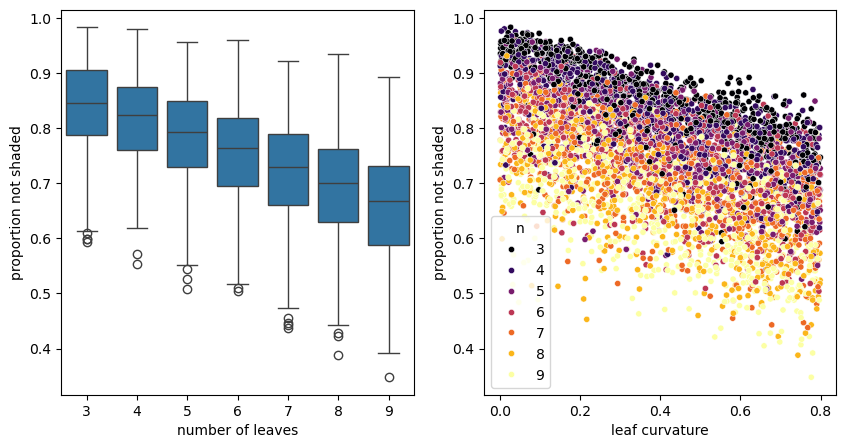

In [8]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.boxplot(data=df, x="n", y="prop_correct")
plt.xlabel("number of leaves")
plt.ylabel("proportion not shaded")

plt.subplot(1,2,2)
sns.scatterplot(data=df, x="leaf_curve", y="prop_correct", hue="n", palette="inferno", s=20)
plt.xlabel("leaf curvature")
plt.ylabel("proportion not shaded")

Get shapes and parameter values by quantile

In [4]:
quants = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1] # get quant levels
n_levels = sorted(df["n"].unique()) # get the levels of leaf number n

n_quant_arr = np.zeros((7,10,5,200,2)) # leaf num, quantile, leaf series, landmark, coordinate vals
nq_leaf_curve = [] # list of lists, by leaf number and quantile, for average parameter values
nq_leaf_curl = []
nq_leaf_tip = []
nq_leaf_mid = []

for n in range(len(n_levels)): # for each level of leaf number

    # mask out the current leaf number
    dfn = df[df["n"]==n_levels[n]]

    quant_arr = np.zeros((10,5,200,2))
    q_leaf_curve = []
    q_leaf_curl = []
    q_leaf_tip = []
    q_leaf_mid = []
    
    for i in range(len(quants)-1):
        inds = dfn[(dfn["prop_correct"]>=np.quantile(dfn["prop_correct"],quants[i])) & (dfn["prop_correct"]<np.quantile(dfn["prop_correct"],quants[i+1]))].index
        quant_arr[i,:,:] = np.mean(arr[inds], axis=0)
    
        q_leaf_curve.append(np.mean(df["leaf_curve"][inds]))
        q_leaf_curl.append(np.mean(df["leaf_curl"][inds]))
        q_leaf_tip.append(np.mean(df["leaf_tip"][inds]))
        q_leaf_mid.append(np.mean(df["leaf_mid"][inds]))


    n_quant_arr[n,:,:,:,:] = quant_arr
    nq_leaf_curve.append(q_leaf_curve)
    nq_leaf_curl.append(q_leaf_curl)
    nq_leaf_tip.append(q_leaf_tip)
    nq_leaf_mid.append(q_leaf_mid)
    

Get 3D leaf points by leaf number and quantile

In [5]:
nq_lf_series_3D = [] # list of lists, leaf num by quantile first levels

for n in range(len(n_levels)): # for each level of leaf number

    quant_arr = n_quant_arr[n] # select the current quantile array by leaf number
    q_leaf_curve = nq_leaf_curve[n] # select the current quantile parameter sets by leaf number
    q_leaf_curl = nq_leaf_curl[n]
    q_leaf_tip = nq_leaf_tip[n]
    q_leaf_mid = nq_leaf_mid[n]
    
    # for q quantiles in quant_arr
    q_lf_series_3D = [] # a list by quantile of 3D leaf points
    
    for q in range(len(quant_arr)):
        
        leaf_curve = q_leaf_curve[q]
        leaf_curl = q_leaf_curl[q]
        leaf_tip = q_leaf_tip[q]
        leaf_mid = q_leaf_mid[q]
        
        # SAMPLE HEX GRID
        pts, tris = sample_hex_grid(scaled_lfs=quant_arr[q],grid_density=grid_density)
        
        lf_series_3D = []
        # for each leaf  in the current quantile q
        for i in range(len(pts)): 
            # LEAF CURVATURE
            # get distances of each grid point to polygon boundary
            dists=[]
            for j in range(len(pts[i])):
                dists.append(shortest_distance_to_polygon((pts[i][j,0],pts[i][j,1]),quant_arr[q][i]))
            scaled_lf_curve = np.array(dists)*leaf_curve # get scaled leaf curvature
        
            # LEAF CURL
            # calculate leaf curl from distance to base
            coeffs = np.polyfit(x=[0,0.5,1], y=[0,leaf_mid,leaf_tip], deg=2) # calculate coefficients
            func = np.poly1d(coeffs) # calculate 2D polynomial function
            
            lf_curl_vals = func(pts[i][:,1])*leaf_curl*np.max(pts[i][:,1]) # calculate leaf lengths relative to 1
            
            # OVERALL Z SURFACE CALCULATION
            lf_surf_vals = scaled_lf_curve+lf_curl_vals # calculate overall curvature
            lf_surf = np.column_stack((pts[i], lf_surf_vals)) # combine x, y, and z vals
            lf_series_3D.append(lf_surf)
    
        q_lf_series_3D.append(lf_series_3D)

    nq_lf_series_3D.append(q_lf_series_3D)
    

Get min and max z value to normalize color scale to

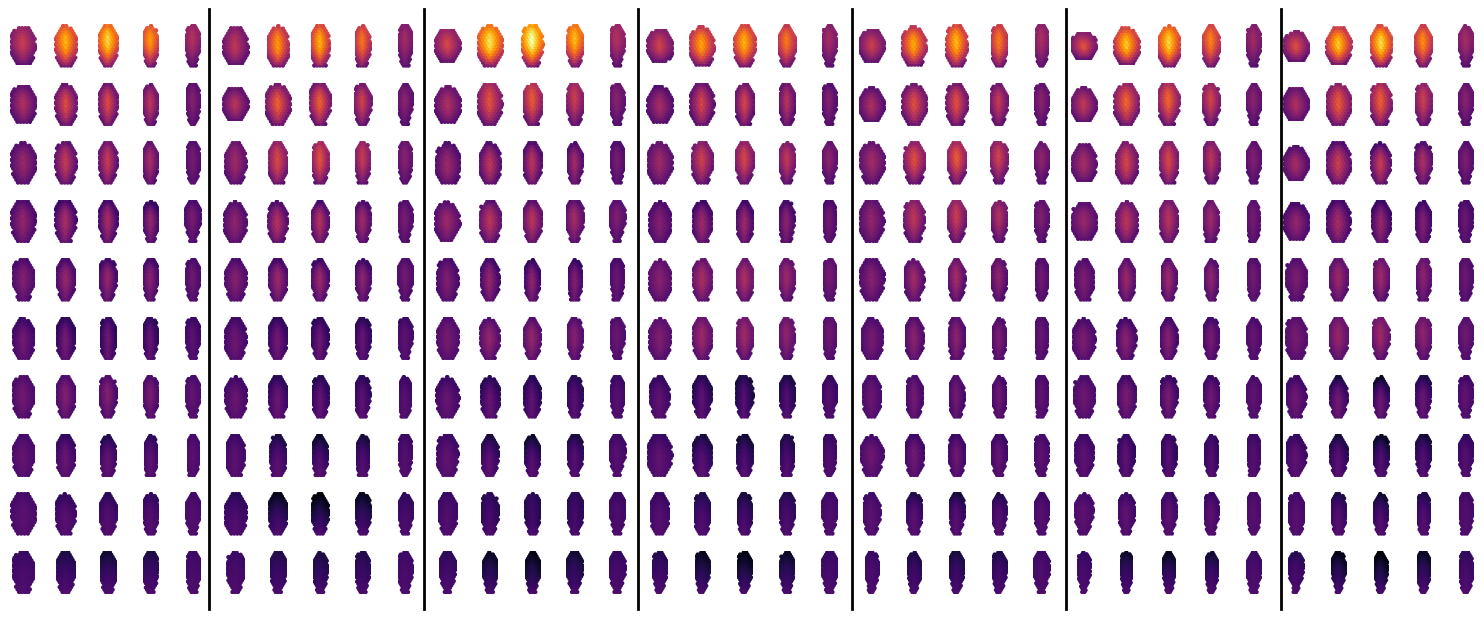

In [6]:
# nq_lf_series_3D
# 0: list of 7 levels, number of leaves
# 1: list of 10 levels, quantiles
# 2: list of 5 levels, leaf series
# 3: a 2D array, landmarks x x/y/z coord vals

zmax_list = []
for n in range(len(nq_lf_series_3D)):
    for q in range(len(nq_lf_series_3D[n])):
        for i in range(len(nq_lf_series_3D[n][q])):
            zmax_list.append(np.max(nq_lf_series_3D[n][q][i][:,2]))
zmax = np.max(zmax_list)

zmin_list = []
for n in range(len(nq_lf_series_3D)):
    for q in range(len(nq_lf_series_3D[n])):
        for i in range(len(nq_lf_series_3D[n][q])):
            zmin_list.append(np.min(nq_lf_series_3D[n][q][i][:,2]))
zmin = np.min(zmin_list)

nrows = 10 # number of quantiles
ncols = 7*5 # number of leaf number levels * number of leaves in the series

plt.figure(figsize=(15,6))
pt_s = 10
count=1

for q in range(10): # for each quantile
    for n in range(7): # for each level of leaf number
        lf_series_3D = nq_lf_series_3D[n][q] # select the current 3D leaf series

        for i in range(len(lf_series_3D)):
            
            plt.subplot(nrows,ncols,count)
            #plt.plot(quant_arr[q][i][:,0], quant_arr[q][i][:,1], c="k")
            sns.scatterplot(x=lf_series_3D[i][:,0], 
                            y=lf_series_3D[i][:,1], 
                            hue=lf_series_3D[i][:,2], 
                            legend=False, 
                            linewidth=0, 
                            palette="inferno",
                            s=pt_s,
                            hue_norm=(zmin,zmax)
                           )
            plt.gca().set_aspect("equal")
            plt.axis("off")
            count+=1

# Add vertical divider lines to the figure
fig = plt.gcf()

for col in range(5, ncols, 5):
    x = col / ncols  # normalized figure coordinate
    line = mlines.Line2D(
        [x, x], [0, 1],  # from bottom to top
        transform=fig.transFigure,  # in figure coordinates
        color='black',
        linewidth=2
    )
    fig.add_artist(line)

plt.tight_layout()
    

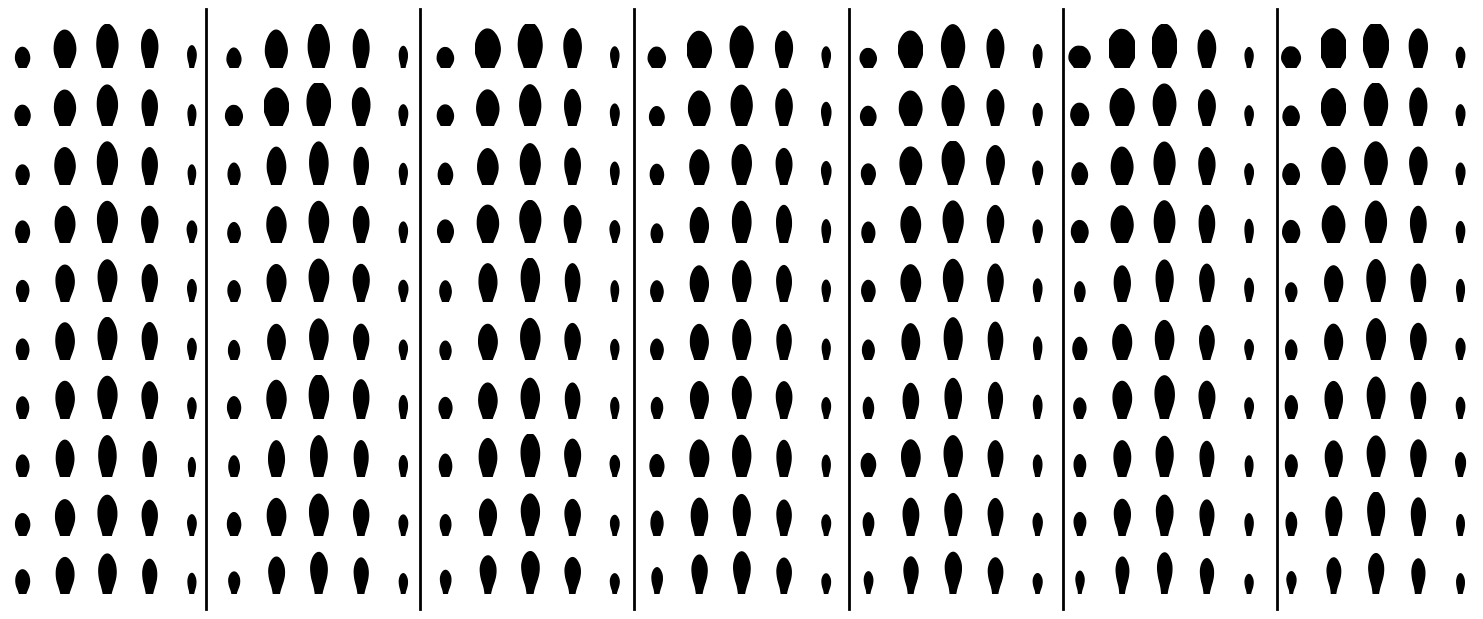

In [7]:
# nq_lf_series_3D
# 0: list of 7 levels, number of leaves
# 1: list of 10 levels, quantiles
# 2: list of 5 levels, leaf series
# 3: a 2D array, landmarks x x/y/z coord vals

xmax_list = []
for n in range(len(nq_lf_series_3D)):
    for q in range(len(nq_lf_series_3D[n])):
        for i in range(len(nq_lf_series_3D[n][q])):
            xmax_list.append(np.max(nq_lf_series_3D[n][q][i][:,0]))
xmax = np.max(xmax_list)

xmin_list = []
for n in range(len(nq_lf_series_3D)):
    for q in range(len(nq_lf_series_3D[n])):
        for i in range(len(nq_lf_series_3D[n][q])):
            xmin_list.append(np.min(nq_lf_series_3D[n][q][i][:,0]))
xmin = np.min(xmin_list)

ymax_list = []
for n in range(len(nq_lf_series_3D)):
    for q in range(len(nq_lf_series_3D[n])):
        for i in range(len(nq_lf_series_3D[n][q])):
            ymax_list.append(np.max(nq_lf_series_3D[n][q][i][:,1]))
ymax = np.max(ymax_list)

ymin_list = []
for n in range(len(nq_lf_series_3D)):
    for q in range(len(nq_lf_series_3D[n])):
        for i in range(len(nq_lf_series_3D[n][q])):
            ymin_list.append(np.min(nq_lf_series_3D[n][q][i][:,1]))
ymin = np.min(ymin_list)

nrows = 10 # number of quantiles
ncols = 7*5 # number of leaf number levels * number of leaves in the series

plt.figure(figsize=(15,6))
pt_s = 10
count=1

for q in range(10): # for each quantile
    for n in range(7): # for each level of leaf number
        #n_quant_arr = np.zeros((7,10,5,200,2))
        quant_arr = n_quant_arr[n]

        
        #lf_series_3D = nq_lf_series_3D[n][q] # select the current 3D leaf series

        for i in range(len(lf_series_3D)):
            
            plt.subplot(nrows,ncols,count)
            plt.fill(quant_arr[q][i][:,0], quant_arr[q][i][:,1], c="k")
            #sns.scatterplot(x=lf_series_3D[i][:,0], 
            #                y=lf_series_3D[i][:,1], 
            #                hue=lf_series_3D[i][:,2], 
            #                legend=False, 
            #                linewidth=0, 
            #                palette="inferno",
            #                s=pt_s,
            #                hue_norm=(zmin,zmax)
            #               )
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
            plt.gca().set_aspect("equal")
            plt.axis("off")
            count+=1

# Add vertical divider lines to the figure
fig = plt.gcf()

for col in range(5, ncols, 5):
    x = col / ncols  # normalized figure coordinate
    line = mlines.Line2D(
        [x, x], [0, 1],  # from bottom to top
        transform=fig.transFigure,  # in figure coordinates
        color='black',
        linewidth=2
    )
    fig.add_artist(line)

plt.tight_layout()

In [9]:
df

,n,phyllo_ang,juv_len,adult_len,node_max,leaf_curve,leaf_curl,leaf_tip,leaf_mid,angle_min,angle_max,start_x,start_y,end_x,end_y,prop_correct,total_area,id
0,6,-137.507764,0.514098,0.270670,0.378137,0.519092,0.490867,-0.564062,-0.521730,8.644446,14.290623,0.270927,-0.087786,0.117998,0.117998,0.771,1.594356,5631
1,8,-137.507764,0.377528,0.759777,0.614747,0.373368,0.704860,-0.222538,-0.197941,8.773949,80.132215,-0.052450,0.045624,0.013965,0.013965,0.762,0.954803,436
2,8,-137.507764,0.243164,0.727532,0.196644,0.607676,0.303798,0.536426,0.124978,2.189255,38.668490,-0.038826,-0.007524,-0.167832,-0.167832,0.667,0.635349,4888
3,9,-137.507764,0.315716,0.864292,0.140713,0.206383,0.159050,0.380964,0.068014,6.990841,24.799439,0.147968,0.126072,-0.183120,-0.183120,0.714,1.017761,5901
4,6,-137.507764,0.390152,0.521022,0.870347,0.652744,0.778333,-0.458488,-0.083423,7.767643,83.209970,0.425099,-0.148696,-0.013641,-0.013641,0.619,0.863743,7094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5273,7,137.507764,0.347565,0.303029,0.265914,0.161467,0.260411,-0.945355,-0.503689,2.938704,43.903551,-0.109924,-0.091470,0.072383,0.072383,0.855,0.783127,539
5274,9,-137.507764,0.651721,0.651367,0.693402,0.181583,0.225035,0.992145,0.061552,5.015351,53.354887,0.480887,0.035856,0.108766,0.108766,0.661,2.736192,4762
5275,3,-137.507764,0.267525,0.489140,0.388934,0.208768,0.482050,-0.313422,-0.078666,7.198657,74.105787,-0.290343,-0.015687,0.180386,0.180386,0.911,0.187208,2603
5276,5,-137.507764,0.724919,0.747604,0.373179,0.236586,0.619106,0.819145,0.743658,0.265907,39.820232,-0.095239,-0.028683,0.050419,0.050419,0.794,0.525320,4987


In [124]:
model_values_path = "model_values"

files_list = [] # a list of files

# select three low files
for i in range(18):
    inds_low = df[(df["prop_correct"]>=np.quantile(df["prop_correct"],0)) & (df["prop_correct"]<np.quantile(df["prop_correct"],0.1))].index
    low_choice = df["id"].iloc[np.random.choice(inds_low)]
    low_model_df = pd.read_csv("./model_values/m"+str(low_choice)+"_"+parameter_name+".csv")
    file = "m"+str(low_choice)+"_"+parameter_name+".csv"
    files_list.append(file)

# select three high files
for i in range(18):
    inds_high = df[(df["prop_correct"]>=np.quantile(df["prop_correct"],0.9)) & (df["prop_correct"]<np.quantile(df["prop_correct"],1.0))].index
    high_choice = df["id"].iloc[np.random.choice(inds_high)]
    high_model_df = pd.read_csv("./model_values/m"+str(high_choice)+"_"+parameter_name+".csv")
    file = "m"+str(high_choice)+"_"+parameter_name+".csv"
    files_list.append(file)

In [125]:
vertices_list = []
faces_list = []

for file in files_list:

    # specify necessary variables
    leaf_series_path = "leaf_series" # folder name to save leaf shape results
    n_save = 5 # number of comparable leaves in the series for leaf shapes saved
    warp = True # should z values be warped to preserve triangle surface areas
    n_origins = 1000 # number of points on Fibonacci sphere to sample for ray origins
    radius = 2 # radius of Fibonacci sphere
    n_sample = 1000 # number of rays to subsample
    
     # retrieve parameter file name from model values string
    # read in and set parameter values
    param_var_dict = set_params(parameter_name+"_params.csv")
    
    # read in and set model values
    model_var_dict = set_model_values(model_values_path+"/"+file)
    
    # read in pca morphospace and PC values
    pca, PCs = read_in_morphospace(morphospace_file, PC_val_file)
    
    # generate a leaf series
    leaf_series = generate_leaf_series(n,start_x,start_y,end_x,end_y,PCs,PCa,PCb,pca)
    
    # check if any leaf in the series is self-intersecting
    #if any_leaf_self_intersecting(leaf_series): # if a self-intersecting leaf, continue
    #    os.remove(model_values_path+"/"+file)
    #    continue
    
    # translate leaf base to origin
    trans_lfs = translate_base_to_origin(leaf_series)
    
    # scale the lengths of the leaves in the series
    scaled_lfs = scale_leaf_series(node_max, juv_len, adult_len, trans_lfs, n)
    
    # sample hexagonal grid points and indices of triangular faces within each leaf
    pts, tris = sample_hex_grid(scaled_lfs,grid_density)
    
    # create 3D leaf surface
    pts_3D = generate_3D_points(pts,scaled_lfs,leaf_curve,leaf_mid,leaf_tip,leaf_curl,phyllo_ang,warp,angle_min,angle_max, n)
    
    #####
    # NORMALIZE RADIUS TO FARTHEST POINT FROM ORIGIN
    #####
    
    dists = []
    for i in range(len(pts_3D)):
        for j in range(len(pts_3D[i])):
            dists.append(np.sqrt( ((pts_3D[i][j][0])**2 +
                                   (pts_3D[i][j][1])**2 +
                                   (pts_3D[i][j][2])**2)
                                ))
    
    max_dist = np.max(dists) # get the max radius to normalize by
    
    norm_pts_3D = [] # normalize 3D points
    for i in range(len(pts_3D)):
        norm_pts_3D.append(pts_3D[i]/max_dist)
    
    pts_3D = norm_pts_3D
    
    #####
    # CREATE MESH
    #####
    
    # create mesh of first leaf
    mesh = trimesh.Trimesh(vertices=pts_3D[0], faces=tris[0])
    
    # concatenate the meshes of other leaves
    for i in range(1, len(pts_3D)):
        new_mesh = trimesh.Trimesh(vertices=pts_3D[i], faces=tris[i])
        mesh = trimesh.util.concatenate(mesh, new_mesh)
    
    vertices_list.append(mesh.vertices)
    faces_list.append(mesh.faces)
   

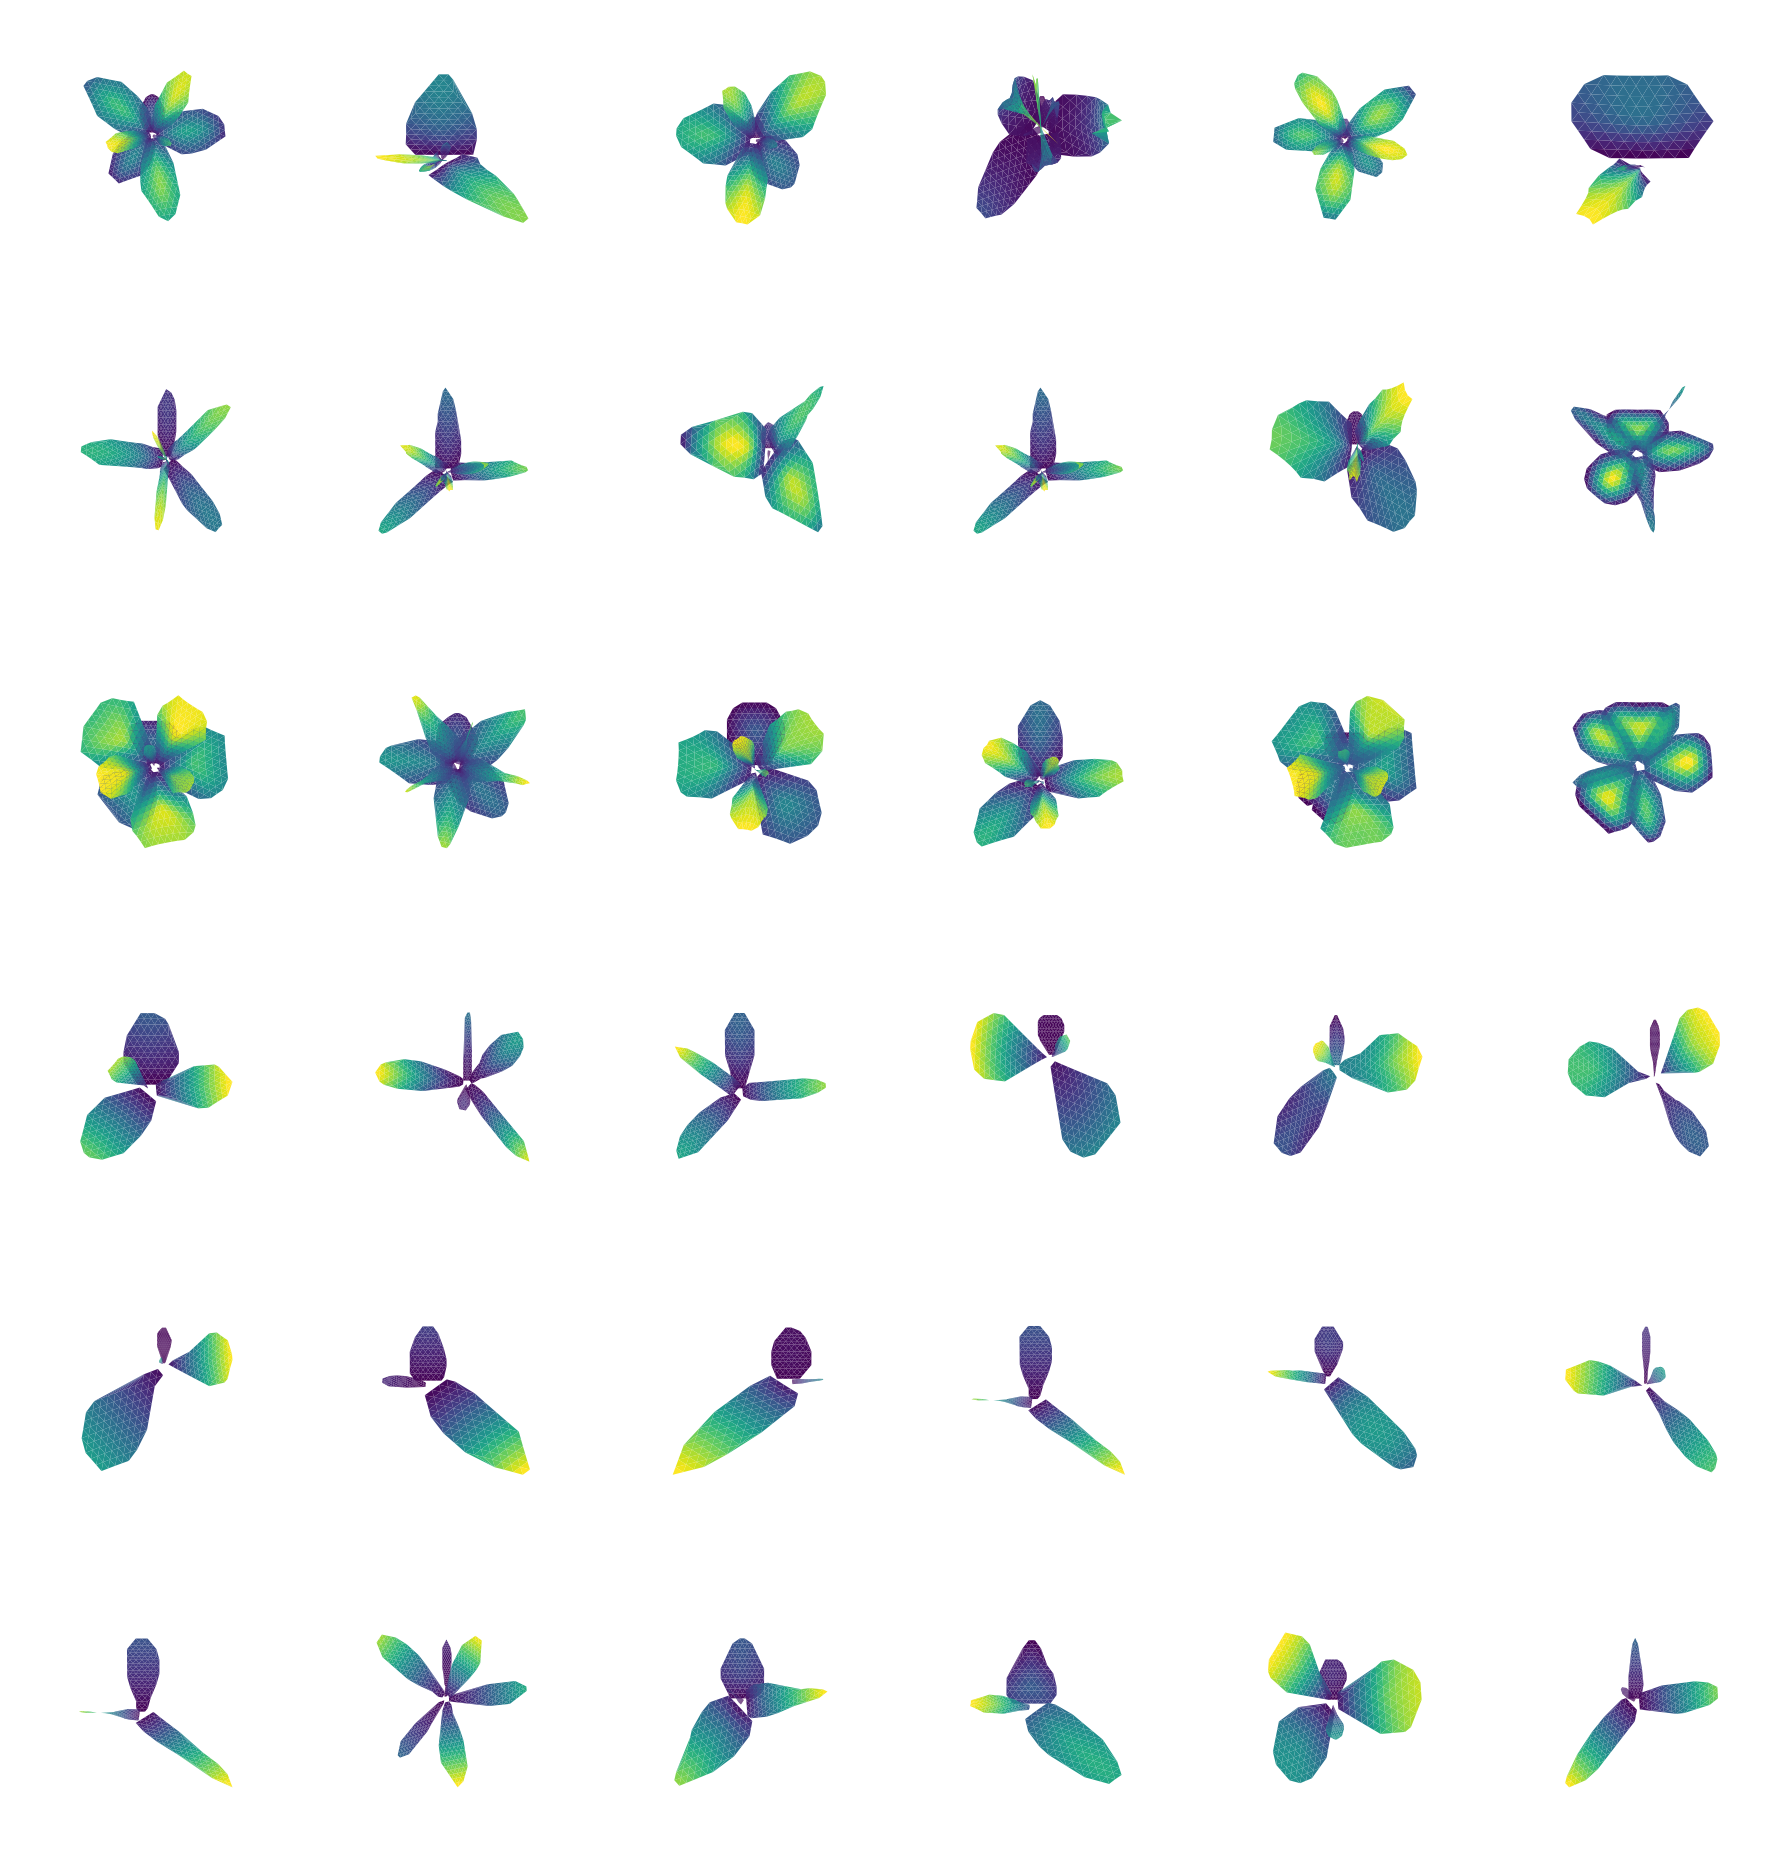

In [133]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# --- Replace with your real mesh data ---
# 36 objects: vertices_list[i], faces_list[i]
#vertices_list = [np.random.rand(100, 3) for _ in range(36)]
#faces_list = [np.random.randint(0, 100, (200, 3)) for _ in range(36)]

# Set top-down view
elev, azim = 90, 0

# Set up 6x6 grid
fig = plt.figure(figsize=(18, 19))  # Square figure for balanced layout

for idx in range(36):
    vertices = vertices_list[idx]
    faces = faces_list[idx]

    ax = fig.add_subplot(6, 6, idx + 1, projection='3d')
    ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2],
                    triangles=faces, cmap='viridis', edgecolor='none', alpha=1.0)
    ax.view_init(elev=elev, azim=azim)
    ax.axis('off')
    ax.set_box_aspect([1, 1, 1])  # Equal aspect ratio

plt.tight_layout()
plt.show()

